In [1]:
import bagpipes as pipes
import numpy as np

Bagpipes: Latex distribution not found, plots may look strange.


Modifico il file con la risposta dei filtri in modo tale da avere 15 files per i 15 filtri, con due colonne riportanti lunghezze d'onda in Angstrom e trasmissione.

In [2]:
with open('COSMOS_photometry/FILTER.RES.UVISTA4.1_trimmed.R300', 'r') as f:
  lines = f.readlines()            #file con curve di trasmissione di tutti i filtri
f.close()

with open('COSMOS_photometry/FILTER.RES.UVISTA4.1_trimmed.R300.info', 'r') as f:
  markers = f.readlines()         #file con info sui filtri, le cui stringhe separano i dati nel precedente, lo uso per separare le curve dei singoli filtri 
f.close()

off = []
for mark in markers:       
 for i,line in enumerate(lines):
   if (line in mark):
    off.append(int(i))
off.append(len(lines))

filter_list = []

for i in range(len(off)-1):      #separo i filtri
   filename = 'filters/filt_%d.txt' % (i+1)
   with open(filename, 'w') as f:
    for line in lines[off[i]+1:off[i+1]]:
      f.write(line)
    filter_list.append(filename)
   f.close()

#print(lines[off[0]+1:off[1]])


In [3]:
import pandas as pd
for filename in filter_list:
  df = pd.read_csv(filename, sep="     ", names=['Number', 'Lambda', 'Transmittance'], engine='python')
  #print(df)
  df = df.drop(columns = 'Number')
  print(df.head(10))
  df.to_csv(filename, sep = ' ', header = False, index = False)

   Lambda  Transmittance
0  9540.0       0.025401
1  9550.0       0.028100
2  9560.0       0.033062
3  9570.0       0.037622
4  9580.0       0.043422
5  9590.0       0.050846
6  9600.0       0.059126
7  9610.0       0.068251
8  9620.0       0.079256
9  9630.0       0.092076
    Lambda  Transmittance
0  11430.0       0.009115
1  11440.0       0.009073
2  11450.0       0.010162
3  11460.0       0.011654
4  11470.0       0.013607
5  11480.0       0.015592
6  11490.0       0.018780
7  11500.0       0.022590
8  11510.0       0.026625
9  11520.0       0.031378
    Lambda  Transmittance
0  14610.0       0.008064
1  14620.0       0.008779
2  14630.0       0.008666
3  14640.0       0.009143
4  14650.0       0.009388
5  14660.0       0.010778
6  14670.0       0.011716
7  14680.0       0.012515
8  14690.0       0.012943
9  14700.0       0.014259
    Lambda  Transmittance
0  19340.0       0.004569
1  19350.0       0.007885
2  19360.0       0.006529
3  19370.0       0.006987
4  19380.0       0.0071

Costruisco un modello all'interno di una funzione, facendo predizioni delle magnitudini nelle bande di interesse

In [28]:
def mag_AB(age, tau, Av, massstar, filter_list):
  exp = {}                          # Tau model star formation history component
  exp["age"] = age                  # Gyr
  exp["tau"] = tau                  # Gyr
  exp["massformed"] = massstar      # log_10(M*/M_solar)
  exp["metallicity"] = 1.           # Z/Z_oldsolar

  dust = {}                         # Dust component
  dust["type"] = "Calzetti"         # Define the shape of the attenuation curve
  dust["Av"] = Av                   # magnitudes

  model_components = {}                   # The model components dictionary
  model_components["redshift"] = 1.0      # Observed redshift  
  model_components["exponential"] = exp   
  model_components["dust"] = dust
  model_components["IMF"] = IMF

  model = pipes.model_galaxy(model_components, filt_list=filter_list, phot_units= 'mujy')
  fluxes = model.photometry
  #fig = model.plot()
  #fig = model.sfh.plot()
  mags = [-2.5*np.log10(flux/(3631*10**6)) for flux in fluxes]
  return mags

In [29]:

print('predicted AB magnitudes',mag_AB(3, 0.75, 0.2, 9, filter_list))


predicted AB magnitudes [26.49245499363532, 26.091379047772012, 25.702559251013017, 25.395141787960736, 29.01421359208004, 28.733586289388132, 28.95469033059506, 28.343406876216225, 27.49746799871721, 26.769490468306824, 29.066524349210013, 25.143866278736738, 25.44560641285142, 25.839731746893623, 26.215386239280832]


In [ ]:
Leggo il catalogo da file

In [9]:
c_list =pd.Index(['id', 'ra', 'dec', 'Ks_tot', 'eKs_tot', 'Ks', 'eKs', 'H', 'eH', 'J', 'eJ','Y', 'eY', 'zp','ezp','ip','eip','rp','erp', 'V','eV','gp','egp','B','eB','u','eu','ch1','ech1','ch2','ech2','ch3','ech3','ch4','ech4'])
df = pd.read_csv('COSMOS_photometry/UVISTA4.1_trimmed.cat', sep=' ', header=None, skipinitialspace= True, skiprows= 2, engine='python')
df.columns = c_list
print(df.head(10))

   id         ra       dec      Ks_tot   eKs_tot          Ks       eKs  \
0   3  150.40550  1.606911   83.582300  1.231353   41.648010  0.331073   
1   4  150.39050  1.604330   12.480370  0.560622    8.833714  0.254183   
2   5  150.40334  1.606078   80.197670  0.917076   44.662380  0.337045   
3  11  150.41180  1.610758  610.410900  2.202923  259.391400  0.639004   
4  13  150.37770  1.608251  126.049200  1.280248   63.677620  0.373997   
5  15  150.41135  1.605257    1.989051  0.235894    2.146189  0.235148   
6  16  150.41338  1.605285    2.310419  0.244106    2.096174  0.235148   
7  18  150.38197  1.606297    6.165348  0.644230    4.141958  0.241120   
8  21  150.40453  1.606700    2.818413  0.333313    2.321243  0.235894   
9  22  150.38472  1.608538   31.433270  0.703577   20.444780  0.283670   

            H        eH           J  ...         u        eu         ch1  \
0   35.248260  0.253064   25.341820  ...  1.824820  0.093686   32.894920   
1    6.042175  0.211260    4.2345

Carico i dati della prima galassia (id 3)

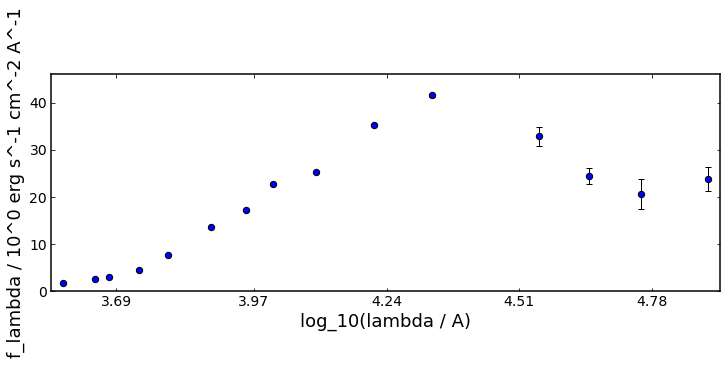

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='log_10(lambda / A)', ylabel='f_lambda / 10^0 erg s^-1 cm^-2 A^-1'>])

In [30]:
def load_data(Id):
    c_list =pd.Index(['id', 'ra', 'dec', 'Ks_tot', 'eKs_tot', 'Ks', 'eKs', 'H', 'eH', 'J', 'eJ','Y', 'eY', 'zp','ezp','ip','eip','rp','erp', 'V','eV','gp','egp','B','eB','u','eu','ch1','ech1','ch2','ech2','ch3','ech3','ch4','ech4'])
    df = pd.read_csv('COSMOS_photometry/UVISTA4.1_trimmed.cat', sep=' ', header=None, skipinitialspace= True, skiprows= 2, engine='python')
    df.columns = c_list
    flux = [ 'Y', 'J', 'H', 'Ks', 'B', 'V', 'gp', 'rp', 'ip', 'zp', 'u', 'ch1', 'ch2', 'ch3', 'ch4']
    flux_err = [ 'eY', 'eJ', 'eH', 'eKs', 'eB', 'eV', 'egp', 'erp', 'eip', 'ezp', 'eu', 'ech1', 'ech2', 'ech3', 'ech4']
    photometry=np.column_stack(([df.loc[df['id'] == int(Id), flux[l]] for l in range(15)],[df.loc[df['id'] == int(Id), flux_err[l]] for l in range(15)]))
    return photometry

galaxy = pipes.galaxy(ID= '3', load_data= load_data, spectrum_exists = False, out_units='mujy', filt_list = filter_list)
galaxy.plot()

In [31]:
print(galaxy.photometry)

[[1.02032759e+04 2.27999900e+01 1.89237900e-01]
 [1.24993110e+04 2.53418200e+01 1.90730900e-01]
 [1.63816700e+04 3.52482600e+01 2.53063700e-01]
 [2.14976583e+04 4.16480100e+01 3.31073000e-01]
 [4.42713421e+03 2.58475800e+00 3.73250200e-02]
 [5.45484985e+03 4.40286000e+00 5.22550300e-02]
 [4.72838533e+03 3.12037200e+00 3.20995200e-02]
 [6.24895357e+03 7.69194100e+00 7.68895500e-02]
 [7.64588905e+03 1.37206800e+01 8.32348100e-02]
 [9.01091189e+03 1.71896700e+01 1.27651600e-01]
 [3.81332031e+03 1.82482000e+00 9.36858100e-02]
 [3.54392858e+04 3.28949200e+01 2.00360700e+00]
 [4.48408365e+04 2.44747600e+01 1.70500700e+00]
 [5.71638984e+04 2.06452200e+01 3.14911200e+00]
 [7.82833732e+04 2.38887600e+01 2.58849100e+00]]


Fitting, inizio con un modello semplice (come esempio)

In [33]:
burst = {}
burst["age"] = (0., 15.)                  # Vary age from 0 to 15 Gyr
burst["metallicity"] = (0., 2.5)          # Vary metallicity from 0 to 2.5 Solar
burst["metallicity_prior"] = "Gaussian"
burst["metallicity_prior_mu"] = 1.
burst["metallicity_prior_sigma"] = .5
burst["massformed"] = (0., 13.)           # Vary log_10(mass formed) from 0 to 13
"""
exp = {}                                  # Tau-model star-formation history component
exp["age"] = (0.1, 15.)                   # Vary age between 100 Myr and 15 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.

exp["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
exp["massformed"] = (1., 15.)             # vary log_10(M*/M_solar) between 1 and 15
exp["metallicity"] = (0., 2.5)            # vary Z between 0 and 2.5 Z_oldsolar
"""
dust = {}                                 # Dust component
dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
dust["Av"] = (0., 2.)                     # Vary Av between 0 and 2 magnitudes

fit_instructions = {}
fit_instructions["burst"] = burst         # Add the burst sfh component to the fit
fit_instructions["redshift"] = (0., 10.)  # Vary observed redshift from 0 to 10
fit_instructions["redshift_prior"] = "Gaussian"
fit_instructions["redshift_prior_mu"] = 0.7
fit_instructions["redshift_prior_sigma"] = 0.
fit_instructions["dust"] = dust

fit = pipes.fit(galaxy, fit_instructions)

fit.fit(verbose=False, use_MPI=False)


Bagpipes: fitting object 3

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************
 ln(ev)=  -72511.306707380747      +/-   3.1721916985091941E-002
 Total Likelihood Evaluations:          683
 Sampling finished. Exiting MultiNest

Completed in 3.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
burst:age                      1.539      4.501      8.197
burst:massformed               2.349      6.567     10.648
burst:metallicity              0.525      1.049      1.516
dust:Av                        0.289      1.021      1.720
redshift                       0.700      0.700      0.700




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.log10(self.sfr*self.age_of_universe) - self.formed_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars